# Predcition of Hospital Admission Related to Infections

In this notebook, we develop a Cox proportional hazard regression model to predict the risk of hospital admission for common infections including urinary tract infection (UTI), upper respiratory tract infection (URTI), lower respiratory tract infection (LRTI), sinusitis, otitis media or middle ear infection (ot media), and ear infection or otitis externa (ot externa).

In [187]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
# import sklearn
# from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pickle
%matplotlib inline

In [188]:
#os.chdir("..")
current_working_dir = os.getcwd()
print(current_working_dir)

c:\Users\m84300af\OneDrive - The University of Manchester\Documents\GitHub\amr-uom-brit


In [189]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [190]:
def makeFilePath(pathFromWorkspace, fileName):
    workingdir = "/workspace/" if (os.name != "nt") else ""
    filepath = workingdir+pathFromWorkspace+fileName

    return filepath

In [191]:
def create_histplot(title, df, ax):
    ax.hist(df, color = 'purple', edgecolor = 'black', bins=20)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=0)

In [192]:
def create_lineplot(var, title, legend_title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-03", color='black', ls='--', lw=1.5)

In [193]:
def create_lineplot_hue(var, hue, title, legend_title, ax1):
    a = data_inclusions_exlusions.groupby(['date', var, hue]).size().reset_index()
    a.columns = ['date', var, hue, 'Freq']
    a = a[a[var] != 0]
    sns.lineplot(x='date', y='Freq', 
            hue=hue, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Frequency')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-03", color='black', ls='--', lw=1.5)

## 1- Data Preparation
### 1-1- Data collection

In [194]:
# data2019_month = {}
# data2020_month = {}
# data2021_month = {}
# data2019 = []
# data2020 = []
# data2021 = []
# for  i in range(1, 13):
#     # data of 2019
#     input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2019-"+str(i).zfill(2)+"-01.csv.gz")
#     data2019_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
#     data2019_month["%s" %i]['date'] = "2019-"+str(i).zfill(2)
#     data2019.append(data2019_month["%s" %i])
#     # data of 2020
#     input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2020-"+str(i).zfill(2)+"-01.csv.gz")
#     data2020_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
#     data2020_month["%s" %i]['date'] = "2020-"+str(i).zfill(2)
#     data2020.append(data2020_month["%s" %i])
#     # data of 2021
#     input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2021-"+str(i).zfill(2)+"-01.csv.gz")
#     data2021_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
#     data2021_month["%s" %i]['date'] = "2021-"+str(i).zfill(2)
#     data2021.append(data2021_month["%s" %i])
    
# data2019 = pd.concat(data2019_month, axis=0, ignore_index=True)
# data2020 = pd.concat(data2020_month, axis=0, ignore_index=True)
# data2021 = pd.concat(data2021_month, axis=0, ignore_index=True)

# data = data2019.append([data2020, data2021], ignore_index=True)

In [195]:
data2019_month = {}
data2020_month = {}
data2021_month = {}
data2019 = []
data2020 = []
data2021 = []
for  i in range(1, 13):
    # data of 2019
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2019-"+str(i).zfill(2)+"-01.csv.gz")
    data2019_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2019_month["%s" %i]['date'] = "2019-"+str(i).zfill(2)
    if i<4:
        data2019_month["%s" %i]['season'] = "Winter"
    elif (i>3) and (i<7):
        data2019_month["%s" %i]['season'] = "Spring"
    elif (i>6) and (i<10):
        data2019_month["%s" %i]['season'] = "Summer"
    elif i>9:
        data2019_month["%s" %i]['season'] = "Autumn"
    data2019.append(data2019_month["%s" %i])
    # data of 2020
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2020-"+str(i).zfill(2)+"-01.csv.gz")
    data2020_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2020_month["%s" %i]['date'] = "2020-"+str(i).zfill(2)
    if i<4:
        data2020_month["%s" %i]['season'] = "Winter"
    elif (i>3) and (i<7):
        data2020_month["%s" %i]['season'] = "Spring"
    elif (i>6) and (i<10):
        data2020_month["%s" %i]['season'] = "Summer"
    elif i>9:
        data2020_month["%s" %i]['season'] = "Autumn"
    data2020.append(data2020_month["%s" %i])
    # data of 2021
    input_file_path = makeFilePath("output/hospitalisation_data/", "input_hospitalisation_2021-"+str(i).zfill(2)+"-01.csv.gz")
    data2021_month["%s" %i] = pd.read_csv(input_file_path, compression='gzip')
    data2021_month["%s" %i]['date'] = "2021-"+str(i).zfill(2)
    if i<4:
        data2021_month["%s" %i]['season'] = "Winter"
    elif (i>3) and (i<7):
        data2021_month["%s" %i]['season'] = "Spring"
    elif (i>6) and (i<10):
        data2021_month["%s" %i]['season'] = "Summer"
    elif i>9:
        data2021_month["%s" %i]['season'] = "Autumn"
    data2021.append(data2021_month["%s" %i])
    
data2019 = pd.concat(data2019_month, axis=0, ignore_index=True)
data2020 = pd.concat(data2020_month, axis=0, ignore_index=True)
data2021 = pd.concat(data2021_month, axis=0, ignore_index=True)

data = data2019.append([data2020, data2021], ignore_index=True)

In [196]:
data.shape#.loc[2500:2510]#.season.value_counts()#.shape

(36000, 229)

In [197]:
data.describe(include='all')

,bmi_date_measured,smoking_status_date,most_recent_unclear_smoking_cat_date,flu_vaccine_med,flu_vaccine_clinical,sgss_positive,primary_care_covid,covrx1_dat,covrx2_dat,admitted_date,...,metastatic_cancer_comor,mild_liver_comor,mod_severe_liver_comor,mod_severe_renal_comor,mi_comor,peptic_ulcer_comor,peripheral_vascular_comor,patient_id,date,season
count,27000,3600,3600,3600,3600,3600,3600,0.0,18000,10800,...,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000.000000,36000,36000
unique,38,38,38,13,13,1087,1088,NaN,637,1140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,4
top,2022-01,2021-07,2021-12,2018-09,2018-08,2021-11-30,2021-04-15,NaN,2022-01-30,2021-12-04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01,Winter
freq,797,122,115,326,344,10,11,NaN,166,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,9000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,4986.252139,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.300004,0.300004,0.300004,0.300004,0.300004,0.300004,0.300004,2892.856734,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2481.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4983.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7504.000000,NaN,NaN


In [198]:
print(list(data.columns))

['bmi_date_measured', 'smoking_status_date', 'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med', 'flu_vaccine_clinical', 'sgss_positive', 'primary_care_covid', 'covrx1_dat', 'covrx2_dat', 'admitted_date', 'deregistered_date', 'died_date', 'uti_date_1', 'uti_date_2', 'uti_date_3', 'uti_date_4', 'lrti_date_1', 'lrti_date_2', 'lrti_date_3', 'lrti_date_4', 'urti_date_1', 'urti_date_2', 'urti_date_3', 'urti_date_4', 'sinusitis_date_1', 'sinusitis_date_2', 'sinusitis_date_3', 'sinusitis_date_4', 'otmedia_date_1', 'otmedia_date_2', 'otmedia_date_3', 'otmedia_date_4', 'ot_externa_date_1', 'ot_externa_date_2', 'ot_externa_date_3', 'ot_externa_date_4', 'gp_cons_uti_1', 'gp_cons_uti_2', 'gp_cons_uti_3', 'gp_cons_uti_4', 'gp_cons_lrti_1', 'gp_cons_lrti_2', 'gp_cons_lrti_3', 'gp_cons_lrti_4', 'gp_cons_sinusitis_1', 'gp_cons_sinusitis_2', 'gp_cons_sinusitis_3', 'gp_cons_sinusitis_4', 'gp_cons_otmedia_1', 'gp_cons_otmedia_2', 'gp_cons_otmedia_3', 'gp_cons_otmedia_4', 'gp_cons_ot_externa_1', 'g

### 1-2- Calculating Chalson Comorbidity Index
Based on: https://www.nature.com/articles/4500889.pdf?origin=ppub

In [199]:
data['CCI'] = np.nan
col0 = data.columns.get_loc('CCI')

col1 = data.columns.get_loc('cancer_comor')
col2 = data.columns.get_loc('cardiovascular_comor')
col3 = data.columns.get_loc('chronic_obstructive_pulmonary_comor') ##
col4 = data.columns.get_loc('heart_failure_comor') ##
col5 = data.columns.get_loc('connective_tissue_comor')
col6 = data.columns.get_loc('dementia_comor')
col7 = data.columns.get_loc('diabetes_comor')
col8 = data.columns.get_loc('diabetes_complications_comor')
col9 = data.columns.get_loc('hemiplegia_comor')
col10 = data.columns.get_loc('hiv_comor')
col11 = data.columns.get_loc('metastatic_cancer_comor')
col12 = data.columns.get_loc('mild_liver_comor')
col13 = data.columns.get_loc('mod_severe_liver_comor')
col14 = data.columns.get_loc('mod_severe_renal_comor')
col15 = data.columns.get_loc('mi_comor')
col16 = data.columns.get_loc('peptic_ulcer_comor')
col17 = data.columns.get_loc('peripheral_vascular_comor')

col18 = data.columns.get_loc('age')

In [200]:
for idx, x in enumerate(data['CCI']):
    n=0
    #comorbidity component
    if data.iat[idx, col15] == 1:
        n=n+1
    if data.iat[idx, col2] == 1:
        n=n+1 
    if data.iat[idx, col17] == 1:
        n=n+1 
    if data.iat[idx, col3] == 1:
        n=n+1
    if data.iat[idx, col7] == 1:
        n=n+1
    if data.iat[idx, col6] == 1:
        n=n+1
    if data.iat[idx, col16] == 1:
        n=n+1
    if data.iat[idx, col5] == 1:
        n=n+1
    if data.iat[idx, col12] == 1:
        n=n+1
    
    if data.iat[idx, col9] == 1:
        n=n+2
    if data.iat[idx, col14] == 1:
        n=n+2
    if data.iat[idx, col8] == 1:
        n=n+2
    if data.iat[idx, col1] == 1:
        n=n+2
    #if data.iat[idx, col5] == 1: # Leukaemia
    #    n=n+2
    #if data.iat[idx, col12] == 1: # Lymphoma
    #    n=n+2

    if data.iat[idx, col13] == 1:
        n=n+3

    if data.iat[idx, col11] == 1:
        n=n+6
    if data.iat[idx, col10] == 1:
        n=n+6

    #age component
    if data.iat[idx, col18] <= 40:
        n=n+0
    if data.iat[idx, col18] > 40 and data.iat[idx, col18] <= 50:
        n=n+1
    if data.iat[idx, col18] > 50 and data.iat[idx, col18] <= 60:
        n=n+2
    if data.iat[idx, col18] > 60 and data.iat[idx, col18] <= 70:
        n=n+3
    if data.iat[idx, col18] > 70:# and data.iat[idx, col18] <= 80:
        n=n+4
    
    data.iat[idx, col0]=n

data.CCI.value_counts()

2.0     4796
3.0     4490
1.0     4326
4.0     4206
0.0     3409
5.0     3196
6.0     2867
7.0     2257
8.0     1796
9.0     1419
10.0    1061
11.0     734
12.0     555
13.0     335
14.0     215
15.0     120
16.0      95
17.0      51
18.0      37
19.0      22
20.0       7
21.0       3
22.0       3
Name: CCI, dtype: int64

### 1-3- Handling variables with missing values
#### 1-3-1- Drop variables with many missing values
We drop colmns with more than 50 percent missing values as they may not be usable in the prediction model, nor they can be imputed properly.

In [201]:
perc = 50.0
min_count =  int(((100-perc)/100)*data.shape[0] + 1)
data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd']] = data[['age', 'sex', 'CCI', 'bmi', 'antibacterial_brit', 'gp_count', 'imd']].dropna(axis=1, thresh=min_count)
data.shape

(36000, 230)

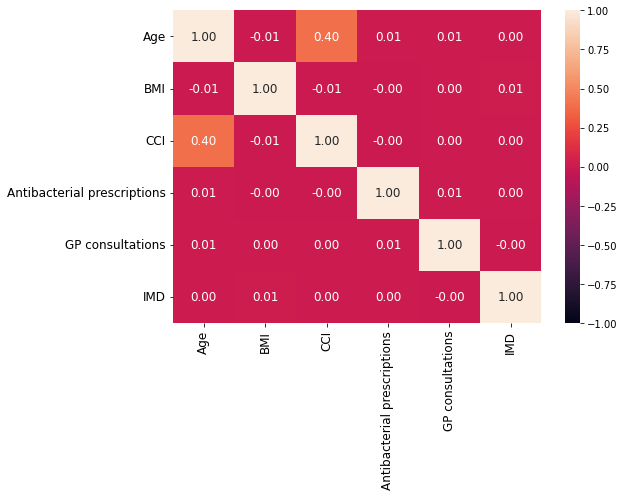

In [202]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.heatmap(data[['age', 'bmi', 'CCI', 'antibacterial_brit', 'gp_count', 'imd' ]].corr(), 
            annot=True, fmt=".2f", annot_kws={"size":12},
            vmin=-1.0, vmax=1.0)

ax.set_xticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD'], rotation=90, fontsize=12)
ax.set_yticklabels(['Age', 'BMI', 'CCI', 'Antibacterial prescriptions', 'GP consultations' , 'IMD'], rotation=0, fontsize=12)                        
plt.tight_layout()
#plt.savefig('../output/hospitalisation_risk/corr_urti.jpg')
plt.show()

#### 1-3-2- Imputation of missing values
We impute variables with missing values that at most 50 pecent of their values are missing.

In [203]:
# prep before plot
data['age'][data['age'] < 0] = np.nan

## remove died cases
#data.died_date.value_counts()

# remove cases with bmi equal 0
data['bmi'][data['bmi'] <= 0] = 0

# remove cases with negative gp_count
data['gp_count'][data['gp_count'] < 0] = np.nan

# remove cases with negative antibacterial_brit
data['antibacterial_brit'][data['antibacterial_brit'] < 0] = np.nan

In [204]:
# imp = SimpleImputer(strategy="most_frequent")
# data[['age', 'bmi_imp']] = imp.fit_transform(data[['age', 'bmi']])

In [207]:
dict_sex = {'F': 0, 'M': 1}
dict_smoking = {'S': 1, 'E': 2, 'N':3, 'M':np.nan}

data = data.replace({"sex": dict_sex})
data = data.replace({"smoking_status": dict_smoking})

In [208]:
# # data['NaN'] = np.nan
# def impute(var, input_1='age', input_2='sex', input_3={}, input_4={}):
#     imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=0)
#     data[var+'_imp'] = np.nan
#     data[var+'_imp'] = imputer.fit_transform(data[[input_1, input_2, input_3, input_4, var]])[:,2]
#     # data = data.drop(['NaN'], axis=1)
#     return data[var+'_imp']

# impute('bmi')

In [209]:
# data = data.drop(['ethnicity_imp'], axis=1)
# data.columns

In [210]:
# if 'bmi' in data.columns:
#     imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=0)
#     data['bmi_imp'] = np.nan
#     data['bmi_imp'] = np.round(imputer.fit_transform(data[['age', 'sex', 'CCI', 'bmi']]))[:,3]

In [211]:
# if 'imd' in data.columns:
#     imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=0)
#     data['imd_imp'] = np.nan
#     data['imd_imp'] = np.round(imputer.fit_transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd']]))[:,4]

In [212]:
# if 'smoking_status' in data.columns:
#     imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=np.nan)
#     data['smoking_status_imp'] = np.nan
#     data['smoking_status_imp'] = np.round(imputer.fit_transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd_imp', 'smoking_status']]))[:,5]

In [213]:
# if 'ethnicity' in data.columns:
#     imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=np.nan)
#     data['ethnicity_imp'] = np.nan
#     data['ethnicity_imp'] = np.round(imputer.fit_transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd_imp', 'smoking_status_imp', 'ethnicity']]))[:,6]

In [214]:
# if ('gp_count' in data.columns) and (data['gp_count'].isnull().sum() > 0):
#     imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=np.nan)
#     data['gp_count_imp'] = np.nan
#     data['gp_count_imp'] = np.round(imputer.fit_transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd_imp', 'smoking_status_imp', 'ethnicity_imp', 'gp_count']]))[:,7]

In [215]:
# if ('antibacterial_brit' in data.columns) and (data['antibacterial_brit'].isnull().sum() > 0):
#     imputer = KNNImputer(n_neighbors=2, weights="uniform", missing_values=np.nan)
#     data['antibacterial_brit_imp'] = np.nan
#     data['antibacterial_brit_imp'] = np.round(imputer.fit_transform(data[['age', 'sex', 'CCI', 'bmi_imp', 'imd_imp', 'smoking_status_imp', 'ethnicity_imp', 'gp_count', 'antibacterial_brit']]))[:,8]

### 1-4- Translating states with dictionaries

In [216]:
# define dictionaries
dict_sex = {0: 'Female', 1: 'Male'}
# dict_imd = {0: 'Unknown', 1: '1 (most deprived)', 2: '2', 3: '3', 4: '4', 5: '5 (least deprived)', np.nan: 'Unknown'}
# dict_ethnicity = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown', np.nan: 'Unknown'}
dict_ethnicity_imp = {1: 'White', 2: 'Mixed', 3: 'Asian', 4: 'Black', 5: 'Other', 0: 'Unknown'}
# dict_smoking = {'E': 'Ex-smoker', 'M': 'Unknown', 'S': 'Smoker', 'N': 'Never smoked'}
dict_smoking = {1:'Smoker', 2:'Ex-smoker', 3:'Never smoked'}
dict_flu = {0: 'No', 1: 'Yes'}

In [217]:
# reoplace values of dictionaries with existing ones
data = data.replace({"sex": dict_sex})
# data = data.replace({"imd": dict_imd_imp})
data = data.replace({"ethnicity_imp": dict_ethnicity_imp})
data = data.replace({"smoking_status": dict_smoking})
data = data.replace({"flu_vaccine": dict_flu})

In [218]:
# categorising 
data['BMI_cat'] = pd.cut(data['bmi_imp'], right=False, bins=[0,18.5,25,30,200], labels=['Underweight', 'Healthy weight', 
                                                                                    'Overweight', 'Obese'])
data['gp_count_cat'] = pd.cut(data['gp_count'], right=False, bins=[0,3,8,12,100], labels=['Few', 'Some', 'Many', 'Too many'])
data['CCI_cat'] = pd.cut(data['CCI'], right=False, bins=[0,1,3,5,8,99], labels=['No', 'Low', 'Moderate', 'High', 'Very high'])
data['Age_cat'] = pd.cut(data['age'], right=False, bins=[0,18,60,200], labels=['0-17 years', '18-59 years', '>59 years'])
#data.CCI_cat.value_counts()

In [219]:
dict_BMI_cat= {'Underweight': 'Underweight', 'Healthy weight': 'Healthy weight', 'Overweight': 'Overweight', 'Obese': 'Obese', 
                np.nan: 'Unknown'}
data = data.replace({"BMI_cat": dict_BMI_cat})

dict_gp_count_cat= {'Few': 'Few', 'Some': 'Some', 'Many': 'Many', 'Too many': 'Too many', np.nan: 'Unknown'}
data = data.replace({"gp_count_cat": dict_gp_count_cat})

dict_smoking_status= {'Smoker': 'Smoker', 'Never smoked': 'Never smoked', 'Ex-smoker': 'Ex-smoker', 'Unknown': 'Unknown', 
                       np.nan: 'Unknown'}
data = data.replace({"smoking_status": dict_smoking_status})

## 2- Plots
### 2-1- Continuous factors

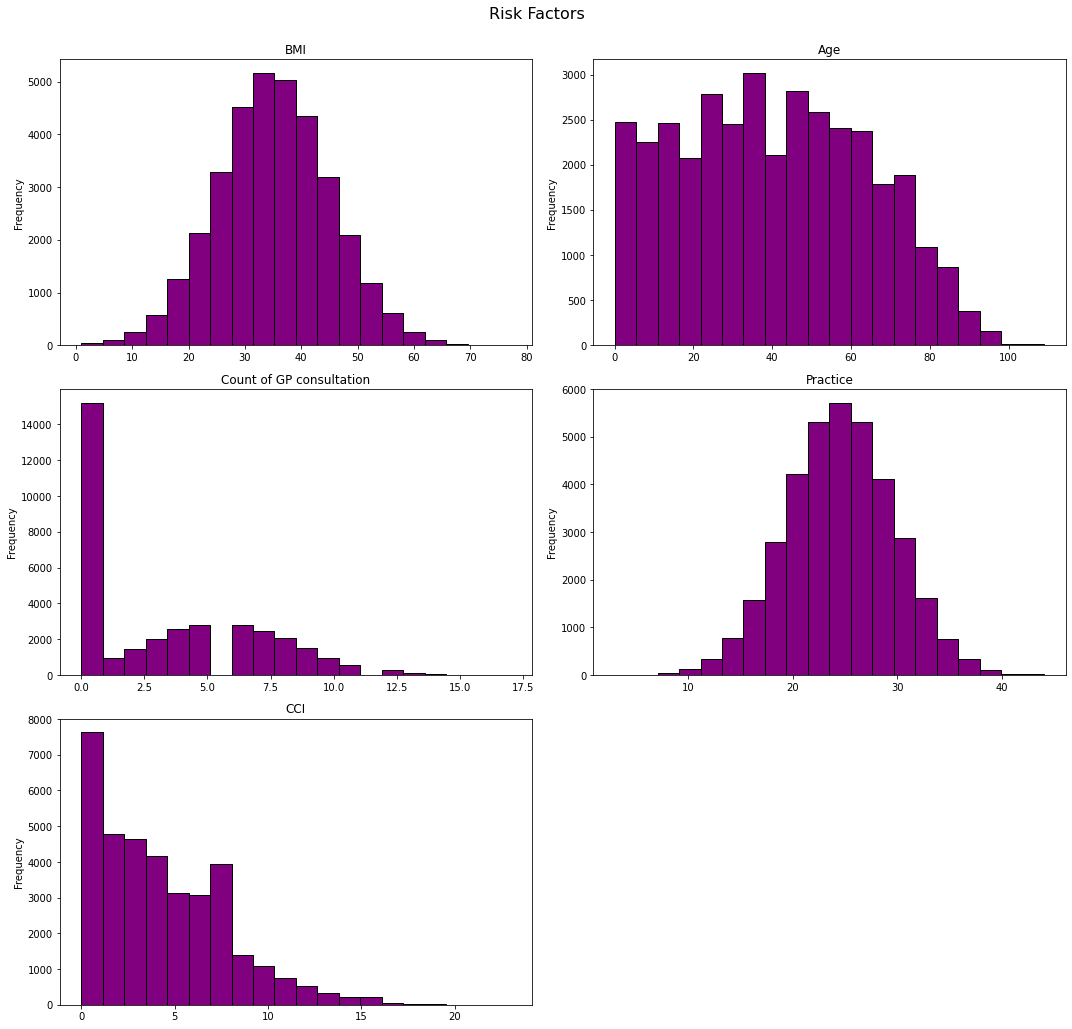

In [18]:
fig, axes = plt.subplots(3,2, 
                        figsize=(15, 15)
                        )
create_histplot('BMI', data['bmi'], axes[0,0])
create_histplot('Age', data['age'], axes[0,1])
create_histplot('Count of GP consultation', data['gp_count'], axes[1,0])
create_histplot('Practice', data['practice'], axes[1,1])
create_histplot('CCI', data['CCI'], axes[2,0])
fig.delaxes(ax=axes[2,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
#plt.savefig('../output/hospitalisation_risk/risk_factors_cont.jpg')
plt.show()

In [589]:
# print(list(data.columns))

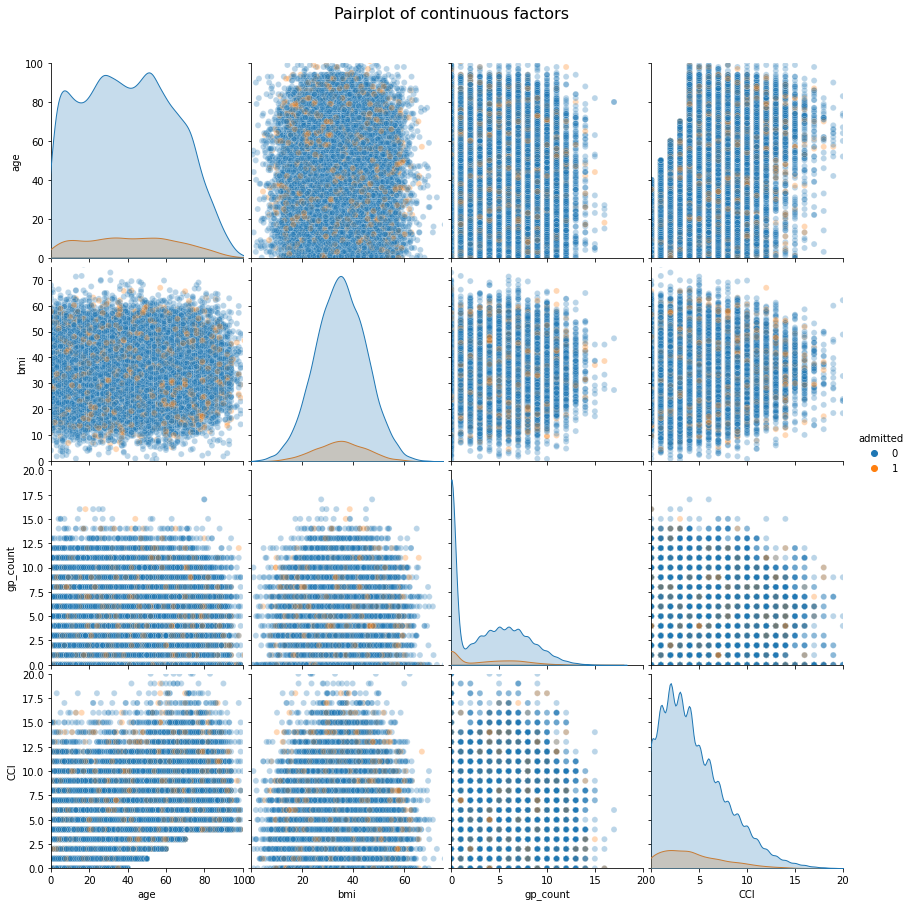

In [20]:
p = sns.pairplot(data, vars=['age', 'bmi', 'gp_count', 'CCI'#, 'practice'
                             ], 
                hue = 'admitted', # 'antibacterial_brit', 
#                kind='reg', 
                #markers=["o", "s"], 
                diag_kind="kde",#"hist"
#                plot_kws={#'line_kws':{'color':'red'}, 
                plot_kws={'alpha':0.3},
                height = 3)

p.axes[0,2].set_xlim((0,20))
p.axes[0,2].set_ylim((0,100))

p.axes[1,1].set_xlim((0,75))
p.axes[1,1].set_ylim((0,75))

p.axes[2,0].set_xlim((0,100))
p.axes[2,0].set_ylim((0,20))

p.axes[0,3].set_xlim((0,20))
p.axes[3,0].set_ylim((0,20))

plt.suptitle('Pairplot of continuous factors', fontsize=16, y=1.05)
#plt.savefig('../output/hospitalisation_risk/risk_factors_cont_pairplot.jpg')
plt.show()

### 2-2- Categorical factors

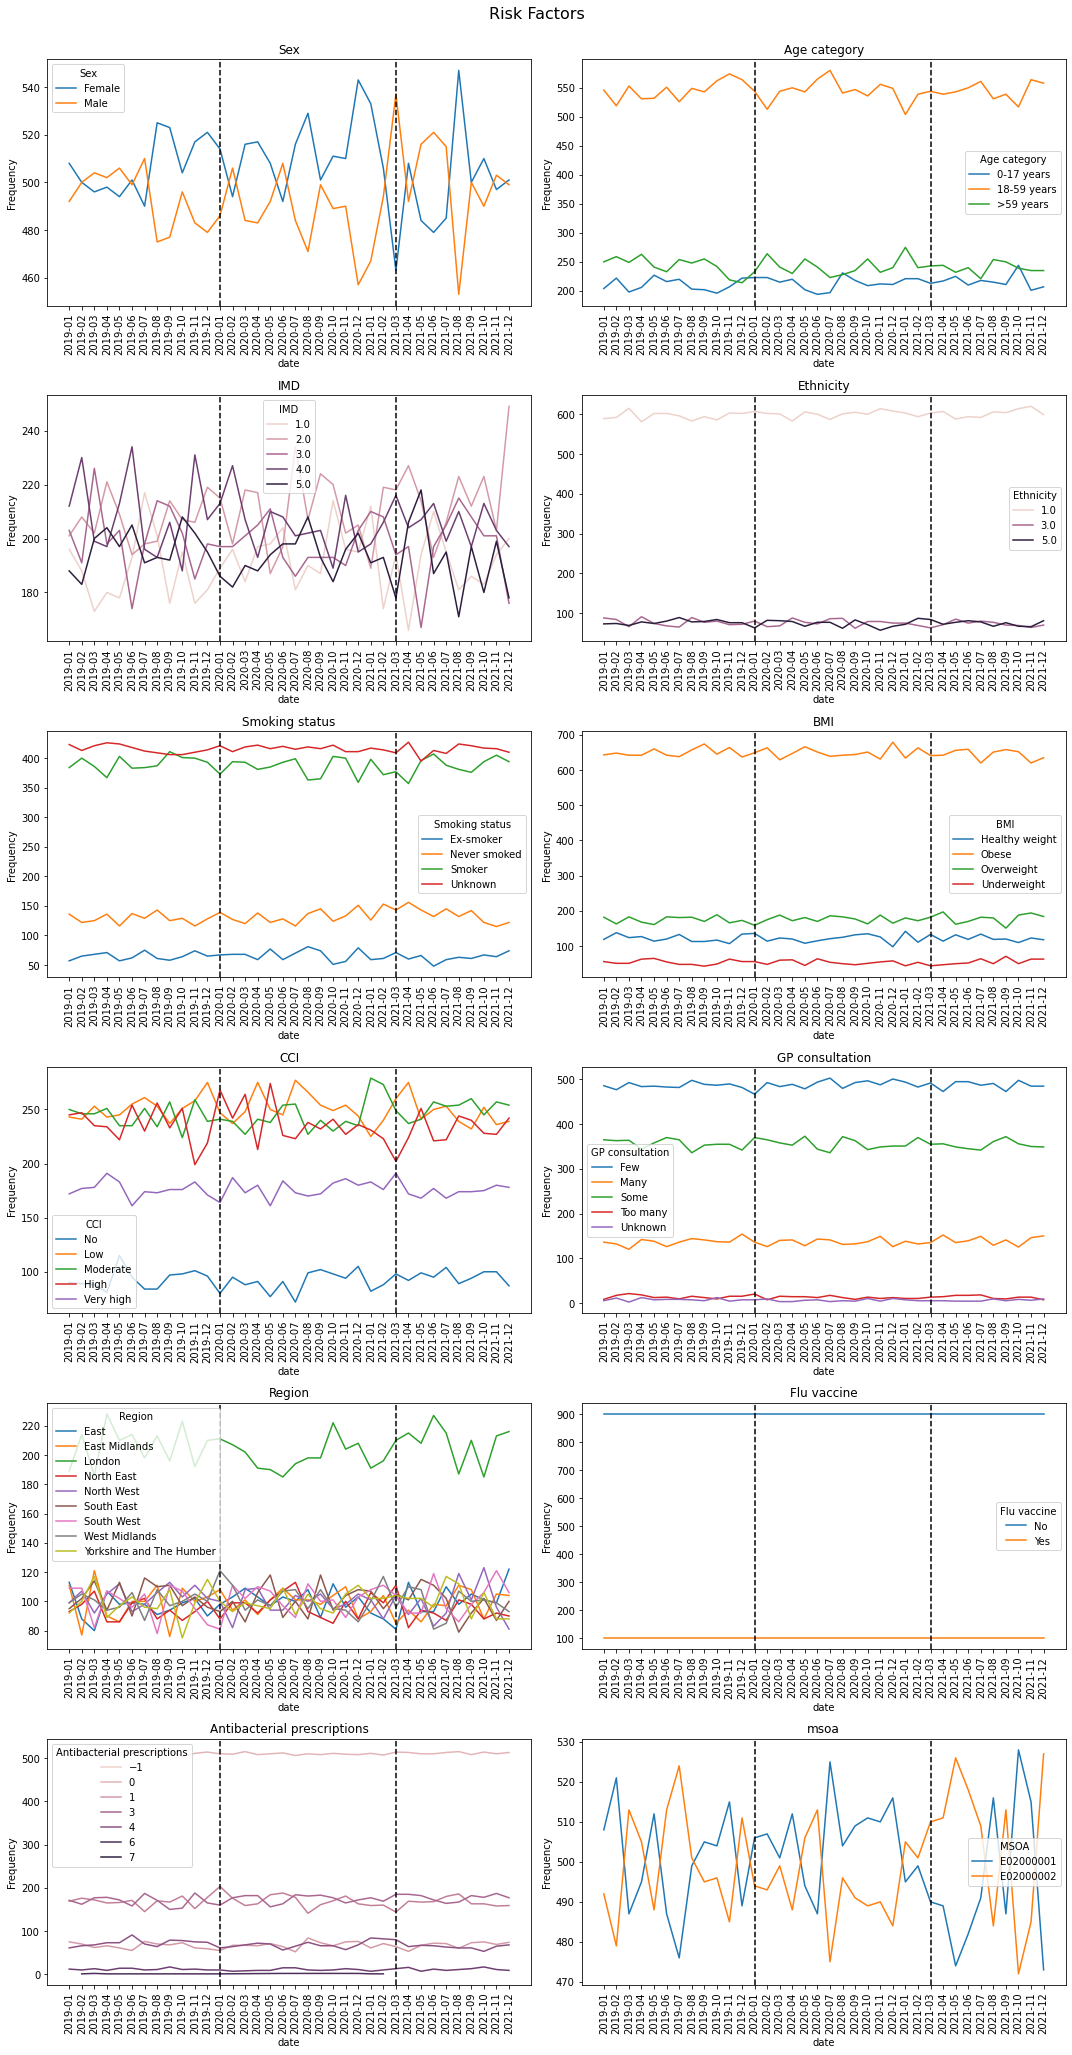

In [339]:
fig, axes = plt.subplots(6,2,
                        figsize=(15, 30)
                        )
create_lineplot('sex', 'Sex', 'Sex', axes[0,0])
create_lineplot('Age_cat', 'Age category', 'Age category', axes[0,1])
create_lineplot('imd_imp', 'IMD', 'IMD', axes[1,0])
create_lineplot('ethnicity', 'Ethnicity', 'Ethnicity', axes[1,1])
create_lineplot('smoking_status', 'Smoking status', 'Smoking status', axes[2,0])
create_lineplot('BMI_cat', 'BMI', 'BMI', axes[2,1])
create_lineplot('CCI_cat', 'CCI', 'CCI', axes[3,0])
create_lineplot('gp_count_cat', 'GP consultation', 'GP consultation', axes[3,1])
create_lineplot('region', 'Region', 'Region', axes[4,0])
create_lineplot('flu_vaccine', 'Flu vaccine', 'Flu vaccine', axes[4,1])
create_lineplot('antibacterial_brit', 'Antibacterial prescriptions', 'Antibacterial prescriptions', axes[5,0])
create_lineplot('msoa', 'msoa', 'MSOA', axes[5,1])
#fig.delaxes(ax=axes[4,1])

fig.suptitle('Risk Factors', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
#plt.savefig('../output/hospitalisation_risk/risk_factors_cat.jpg')
plt.show()

## 3- Data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 3-1- UTI

In [221]:
def ConvertColumns(InfectionKey, NumSets):
    for i in range(1, NumSets+1):        
        arrayKey1 = 'admitted_'+InfectionKey+'_date_'+str(i)
        #arrayKey2 = InfectionKey+'_date_'+str(i)
        data[arrayKey1] = data[arrayKey1].astype('datetime64[ns]')

In [23]:
# def LoadData(InfectionKey, Index):
#     data_1 = data[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'gp_count_cat', 'flu_vaccine', 'region',
#                    'smoking_status', 'antibacterial_brit', 'imd', 'ethnicity', 'CCI_cat', 'CCI', 'hx_hosp', 
#                    'died_date', 'deregistered_date',
#                    'gp_cons_'+InfectionKey+'_'+str(Index), 'gp_cons_'+InfectionKey+'_ab_'+str(Index),
#                    InfectionKey+'_date_'+str(Index), 'incdt_'+InfectionKey+'_date_'+str(Index), 'admitted_'+InfectionKey+'_date_'+str(Index),
#                    'sgss_gp_cov_'+InfectionKey+'_date_'+str(Index)]]

#     data_1 = data_1[data_1[InfectionKey+'_date_'+str(Index)].notnull()]

#         # exclusion of covid positive 90 days before and 30 days after dx with uti_1
#     data_1 = data_1[data_1['sgss_gp_cov_'+InfectionKey+'_date_'+str(Index)] == 0]

#     data_1.rename(columns={InfectionKey+'_date_'+str(Index): InfectionKey+'_date',
#                                                     'incdt_'+InfectionKey+'_date_'+str(Index): 'incdt_'+InfectionKey+'_date',
#                                                     'gp_cons_'+InfectionKey+'_'+str(Index): 'gp_cons_'+InfectionKey,
#                                                     'gp_cons_'+InfectionKey+'_ab_'+str(Index): 'gp_cons_'+InfectionKey+'_ab',
#                                                     'incdt_'+InfectionKey+'_date_'+str(Index): 'incdt_'+InfectionKey+'_date',
#                                                     'admitted_'+InfectionKey+'_date_'+str(Index): 'admitted_'+InfectionKey+'_date',
#                                                     'sgss_gp_cov_'+InfectionKey+'_date_'+str(Index): 'sgss_gp_cov_'+InfectionKey+'_date'},
#                                                     inplace=True)
    
#     #convert types
#     data_1[InfectionKey+'_date'] = data_1[InfectionKey+'_date'].astype('datetime64[ns]')
#     data_1['admitted_'+InfectionKey+'_date'] = data_1['admitted_'+InfectionKey+'_date'].astype('datetime64[ns]')
#     data_1.died_date = data_1.died_date.astype('datetime64[ns]')
#     data_1.deregistered_date = data_1.deregistered_date.astype('datetime64[ns]')

#     #censor patients that were not hosped
#     #data_1 = data_1[data_1['admitted_'+InfectionKey+'_date'].notnull()]
#     data_1.loc[data_1['admitted_'+InfectionKey+'_date'].notnull(), 'event_'+InfectionKey+'_admitted'] = 0
    
#     #calculating days between infection dx and hosp
#     data_1['delta_'+InfectionKey+'_admitted'] = (data_1['admitted_'+InfectionKey+'_date'] - data_1[InfectionKey+'_date']).dt.days
    
#     #censor died patients
#     data_1['delta_admitted_died'] = (data_1['died_date'] - data_1['admitted_'+InfectionKey+'_date']).dt.days
#     #data_1 = data_1[data_1['delta_'+InfectionKey+'_admitted'] > 0]
#     data_1.loc[data_1['delta_admitted_died'] > 0, 'event_'+InfectionKey+'_admitted'] = 0

#     #censor deregistered patients
#     data_1['delta_admitted_deregistered'] = (data_1['deregistered_date'] - data_1['admitted_'+InfectionKey+'_date']).dt.days
#     data_1.loc[((data_1['delta_admitted_deregistered'] > 0) & (data_1['delta_admitted_deregistered'] < 30)), 'event_'+InfectionKey+'_admitted'] = 0

#     #censor patients that had a history of hospital admission
#     # data_1.loc[data_1['hx_hosp'] == 1, 'event_'+InfectionKey+'_admitted'] = 0
    
#     #uncensor any other patients
#     data_1['event_'+InfectionKey+'_admitted'] = data_1['event_'+InfectionKey+'_admitted'].replace(np.NaN, 1)

#     #assign values for duration column
#     data_1['duration_'+InfectionKey+'_admitted'] = data_1['delta_'+InfectionKey+'_admitted'].combine_first(data_1['delta_admitted_died'])
#     data_1['duration_'+InfectionKey+'_admitted'] = data_1['duration_'+InfectionKey+'_admitted'].replace(np.NaN, 30)

#     return data_1

In [235]:
def LoadData(InfectionKey, Index):
    data_1 = data[['age', 'age_cat', 'sex', 'bmi_imp', 'BMI_cat', 'gp_count', 'gp_count_cat', 'flu_vaccine', 'region',
                   'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'hx_hosp', 'CCI_cat', 'CCI',  
                   'died_date', 'deregistered_date',
                   'gp_cons_'+InfectionKey+'_'+str(Index), 'gp_cons_'+InfectionKey+'_ab_'+str(Index),
                   InfectionKey+'_date_'+str(Index), 'incdt_'+InfectionKey+'_date_'+str(Index), 'admitted_'+InfectionKey+'_date_'+str(Index),
                   'sgss_gp_cov_'+InfectionKey+'_date_'+str(Index)]]

    data_1 = data_1[data_1[InfectionKey+'_date_'+str(Index)].notnull()]

        # exclusion of covid positive 90 days before and 30 days after dx with uti_1
    data_1 = data_1[data_1['sgss_gp_cov_'+InfectionKey+'_date_'+str(Index)] == 0]

    data_1.rename(columns={InfectionKey+'_date_'+str(Index): InfectionKey+'_date',
                                                    'incdt_'+InfectionKey+'_date_'+str(Index): 'incdt_'+InfectionKey+'_date',
                                                    'gp_cons_'+InfectionKey+'_'+str(Index): 'gp_cons_'+InfectionKey,
                                                    'gp_cons_'+InfectionKey+'_ab_'+str(Index): 'gp_cons_'+InfectionKey+'_ab',
                                                    'incdt_'+InfectionKey+'_date_'+str(Index): 'incdt_'+InfectionKey+'_date',
                                                    'admitted_'+InfectionKey+'_date_'+str(Index): 'admitted_'+InfectionKey+'_date',
                                                    'sgss_gp_cov_'+InfectionKey+'_date_'+str(Index): 'sgss_gp_cov_'+InfectionKey+'_date'},
                                                    inplace=True)
    
    #convert types
    data_1[InfectionKey+'_date'] = data_1[InfectionKey+'_date'].astype('datetime64[ns]')
    data_1['admitted_'+InfectionKey+'_date'] = data_1['admitted_'+InfectionKey+'_date'].astype('datetime64[ns]')
    data_1.died_date = data_1.died_date.astype('datetime64[ns]')
    data_1.deregistered_date = data_1.deregistered_date.astype('datetime64[ns]')

    #scenario 1
    #not hosped (nothing happened)
    #data_1 = data_1[data_1['admitted_'+InfectionKey+'_date'].notnull()]
    data_1.loc[data_1['admitted_'+InfectionKey+'_date'].notnull(), 'event_'+InfectionKey+'_admitted'] = 0
    
    #scenario 2
    # become a case (uncensoring)
    #calculating days between infection dx and hosp
    data_1['delta_'+InfectionKey+'_admitted'] = (data_1['admitted_'+InfectionKey+'_date'] - data_1[InfectionKey+'_date']).dt.days
    data_1.loc[((data_1['delta_'+InfectionKey+'_admitted'] > 0) & (data_1['delta_'+InfectionKey+'_admitted'] < 30)), 'event_'+InfectionKey+'_admitted'] = 1

    #scenario 3
    #censor died patients
    data_1['delta_admitted_died'] = (data_1['died_date'] - data_1['admitted_'+InfectionKey+'_date']).dt.days
    #data_1 = data_1[data_1['delta_'+InfectionKey+'_admitted'] > 0]
    data_1.loc[data_1['delta_admitted_died'] > 0, 'event_'+InfectionKey+'_admitted'] = 0
    
    #scenario 3
    #censor deregistered patients
    data_1['delta_admitted_deregistered'] = (data_1['deregistered_date'] - data_1['admitted_'+InfectionKey+'_date']).dt.days
    data_1.loc[((data_1['delta_admitted_deregistered'] > 0) & (data_1['delta_admitted_deregistered'] < 30)), 'event_'+InfectionKey+'_admitted'] = 0

    #censor patients that had a history of hospital admission
    # data_1.loc[data_1['hx_hosp'] == 1, 'event_'+InfectionKey+'_admitted'] = 0
    
    #scenario 1
    #any other patients (nothing happened)
    data_1['event_'+InfectionKey+'_admitted'] = data_1['event_'+InfectionKey+'_admitted'].replace(np.NaN, 0)

    #assign values for duration column
    data_1['duration_'+InfectionKey+'_admitted'] = data_1['delta_'+InfectionKey+'_admitted'].combine_first(data_1['delta_admitted_died'])
    data_1['duration_'+InfectionKey+'_admitted'] = data_1['duration_'+InfectionKey+'_admitted'].replace(np.NaN, 30)

    return data_1

In [236]:
# def LoadData(InfectionKey, Index):
#     for  i in range(1, Index+1): 
#         # data_1[i] = data[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine', 'region', 'antibacterial_brit',
#         #                 'imd', 'ethnicity', 'CCI_cat', 'CCI', 'hx_hosp', 'died_date',
#         #                 'gp_cons_'+InfectionKey+'_'+str(i), 'gp_cons_'+InfectionKey+'_ab_'+str(i),
#         #                 InfectionKey+'_date_'+str(i), 'incdt_'+InfectionKey+'_date_'+str(i), 'admitted_'+InfectionKey+'_date_'+str(Index),
#         #                 'sgss_gp_cov_'+InfectionKey+'_date_'+str(i)]]

#         data_1[str(i)] = data[['age', 'age_cat', 'sex', 'bmi', 'BMI_cat', 'gp_count', 'flu_vaccine', 'region', 'antibacterial_brit',
#                         'imd', 'ethnicity', 'CCI_cat', 'CCI', 'hx_hosp', 'died_date',
#                         'gp_cons_'+InfectionKey+'_'+str(i), 'gp_cons_'+InfectionKey+'_ab_'+str(i),
#                         InfectionKey+'_date_'+str(i), 'incdt_'+InfectionKey+'_date_'+str(i), 'admitted_'+InfectionKey+'_date_'+str(Index),
#                         'sgss_gp_cov_'+InfectionKey+'_date_'+str(i)]]        

#         data_1 = data_1[data_1[InfectionKey+'_date_'+str(i)].notnull()]

#         # exclusion of covid positive 90 days before and 30 days after dx with uti_1
#         data_1 = data_1[data_1['sgss_gp_cov_'+InfectionKey+'_date_'+str(i)] == 0]

#         data_1.rename(columns={InfectionKey+'_date_'+str(i): InfectionKey+'_date',
#                                                     'incdt_'+InfectionKey+'_date_'+str(i): 'incdt_'+InfectionKey+'_date',
#                                                     'gp_cons_'+InfectionKey+'_'+str(i): 'gp_cons_'+InfectionKey,
#                                                     'gp_cons_'+InfectionKey+'_ab_'+str(i): 'gp_cons_'+InfectionKey+'_ab',
#                                                     'incdt_'+InfectionKey+'_date_'+str(i): 'incdt_'+InfectionKey+'_date',
#                                                     'admitted_'+InfectionKey+'_date_'+str(i): 'admitted_'+InfectionKey+'_date',
#                                                     'sgss_gp_cov_'+InfectionKey+'_date_'+str(i): 'sgss_gp_cov_'+InfectionKey+'_date'},
#                                                     inplace=True)
#         data_1.append(data_1[i])

#     data_2 = pd.concat(data_1, axis=0, ignore_index=True)

#     #convert 
#     # data_1[InfectionKey+'_date'] = data_1[InfectionKey+'_date'].astype('datetime64[ns]')
#     # data_1['admitted_'+InfectionKey+'_date'] = data_1['admitted_'+InfectionKey+'_date'].astype('datetime64[ns]')
#     # data_1.died_date = data_1.died_date.astype('datetime64[ns]')

#     # #removing any row with no hosp record
#     # data_1 = data_1[data_1['admitted_'+InfectionKey+'_date'].notnull()]
#     # #calculating days between infection dx and hosp
#     # data_1['delta_'+InfectionKey+'_admitted'] = (data_1['admitted_'+InfectionKey+'_date'] - data_1[InfectionKey+'_date']).dt.days
#     # #remove whoever died after getting hosp
#     # data_1['delta_admitted_died'] = (data_1['died_date'] - data_1['admitted_'+InfectionKey+'_date']).dt.days
#     # #data_1 = data_1[data_1['delta_'+InfectionKey+'_admitted'] > 0]

#     # #censor died cases
#     # data_1.loc[data_1['delta_admitted_died'] > 30, 'event_'+InfectionKey+'_admitted'] = 0
#     # #censor cases that had a history of hospital admission
#     # data_1.loc[data_1['hx_hosp'] == 1, 'event_'+InfectionKey+'_admitted'] = 0
#     # #censor cases that left ??
    

#     # #uncensor any other cases
#     # data_1['event_'+InfectionKey+'_admitted'] = data_1['event_'+InfectionKey+'_admitted'].replace(np.NaN, 1)

#     # #assign values for duration column
#     # data_1['duration_'+InfectionKey+'_admitted'] = data_1['delta_'+InfectionKey+'_admitted'].combine_first(data_1['delta_admitted_died'])

#     #splitting data into 
#     # data_2 = data_1[data_1['gp_cons_'+InfectionKey+'_ab'].isnull()]
#     # data_2 = data_2[data_2['incdt_'+InfectionKey+'_date'] == 0]

#     # data_3 = data_1[data_1['gp_cons_'+InfectionKey+'_ab'].notnull()]
#     # data_3 = data_3[data_3['incdt_'+InfectionKey+'_date'] == 0]

#     # data_4 = data_1[data_1['gp_cons_uti_ab'].isnull()]
#     # data_4 = data_4[data_4['incdt_uti_date'] == 1]

#     # data_5 = data_1[data_1['gp_cons_uti_ab'].notnull()]
#     # data_5 = data_5[data_5['incdt_uti_date'] == 1]

#     # return [data_2, data_3, data_4, data_5]
#     return data_2

In [237]:
ConvertColumns("uti", 4)

data_uti_1 = LoadData("uti", 1)
data_uti_2 = LoadData("uti", 2)
data_uti_3 = LoadData("uti", 3)
data_uti_4 = LoadData("uti", 4)

data_uti = pd.concat([data_uti_1, data_uti_2, data_uti_3, data_uti_4])
data_uti.reset_index(inplace=True, drop=True)
data_uti.shape

(351, 29)

#### Separate data of UTI
We separate data of UTI to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [268]:
# no antibiotics and incident hospital admission
data_uti_no_abs_incdt = data_uti[data_uti['gp_cons_uti_ab'].isnull()]
data_uti_no_abs_incdt = data_uti_no_abs_incdt[data_uti_no_abs_incdt['incdt_uti_date'] == 0]

# with antibiotics and incident hospital admission
data_uti_abs_incdt = data_uti[data_uti['gp_cons_uti_ab'].notnull()]
data_uti_abs_incdt = data_uti_abs_incdt[data_uti_abs_incdt['incdt_uti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_uti_no_abs_prevl = data_uti[data_uti['gp_cons_uti_ab'].isnull()]
data_uti_no_abs_prevl = data_uti_no_abs_prevl[data_uti_no_abs_prevl['incdt_uti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_uti_abs_prevl = data_uti[data_uti['gp_cons_uti_ab'].notnull()]
data_uti_abs_prevl = data_uti_abs_prevl[data_uti_abs_prevl['incdt_uti_date'] == 1]

print(f'shape of data_uti_no_abs_incdt: {data_uti_no_abs_incdt.shape}')
print(f'shape of data_uti_abs_incdt: {data_uti_abs_incdt.shape}')
print(f'shape of data_uti_no_abs_prevl: {data_uti_no_abs_prevl.shape}')
print(f'shape of data_uti_abs_prevl: {data_uti_abs_prevl.shape}')

shape of data_uti_no_abs_incdt: (283, 29)
shape of data_uti_abs_incdt: (29, 29)
shape of data_uti_no_abs_prevl: (36, 29)
shape of data_uti_abs_prevl: (3, 29)


### 3-2- URTI

#### Adding event and duration columns for URTI

In [ ]:
ConvertColumns("urti", 4)

data_urti_1 = LoadData("urti", 1)
data_urti_2 = LoadData("urti", 2)
data_urti_3 = LoadData("urti", 3)
data_urti_4 = LoadData("urti", 4)

data_urti = pd.concat([data_urti_1, data_urti_2, data_urti_3, data_urti_4])
data_urti.reset_index(inplace=True, drop=True)
data_urti.shape

#### Separate data of URTI
We separate data of URI to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [270]:
# no antibiotics and incident hospital admission
data_urti_no_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].isnull()]
data_urti_no_abs_incdt = data_urti_no_abs_incdt[data_urti_no_abs_incdt['incdt_urti_date'] == 0]

# with antibiotics and incident hospital admission
data_urti_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].notnull()]
data_urti_abs_incdt = data_urti_abs_incdt[data_urti_abs_incdt['incdt_urti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_urti_no_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].isnull()]
data_urti_no_abs_prevl = data_urti_no_abs_prevl[data_urti_no_abs_prevl['incdt_urti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_urti_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].notnull()]
data_urti_abs_prevl = data_urti_abs_prevl[data_urti_abs_prevl['incdt_urti_date'] == 1]

print(f'shape of data_urti_no_abs_incdt: {data_urti_no_abs_incdt.shape}')
print(f'shape of data_urti_abs_incdt: {data_urti_abs_incdt.shape}')
print(f'shape of data_urti_no_abs_prevl: {data_urti_no_abs_prevl.shape}')
print(f'shape of data_urti_abs_prevl: {data_urti_abs_prevl.shape}')

shape of data_urti_no_abs_incdt: (268, 29)
shape of data_urti_abs_incdt: (26, 29)
shape of data_urti_no_abs_prevl: (31, 29)
shape of data_urti_abs_prevl: (3, 29)


## 4- Cox modelling for hospital admissions related to infections 
### 4-1- UTI

In [242]:
data_uti_no_abs_incdt.shape

(283, 29)

In [266]:
def CoxModel(InfectionKey):
    data_uti_no_abs_incdt_nonan = data_uti_no_abs_incdt[['age', 'sex', 'BMI_cat', 'gp_count_cat', #'bmi', 'gp_count',
                                    'flu_vaccine', 'region', 'antibacterial_brit', 'hx_hosp', 'imd_imp', 'ethnicity_imp', 
                                    'smoking_status_imp', 'CCI_cat', 'CCI', 
                                    'event_'+InfectionKey+'_admitted', 'duration_'+InfectionKey+'_admitted']]

    data_uti_abs_incdt_nonan = data_uti_abs_incdt[['age', 'sex', 'BMI_cat', 'gp_count_cat', #'bmi', 'gp_count',
                                    'flu_vaccine', 'region', 'antibacterial_brit', 'hx_hosp', 'imd_imp', 'ethnicity_imp', 
                                    'smoking_status_imp', 'CCI_cat', 'CCI', 
                                    'event_'+InfectionKey+'_admitted', 'duration_'+InfectionKey+'_admitted']]

    data_uti_no_abs_prevl_nonan = data_uti_no_abs_prevl[['age', 'sex', 'BMI_cat', 'gp_count_cat', #'bmi', 'gp_count',
                                    'flu_vaccine', 'region', 'antibacterial_brit', 'hx_hosp', 'imd_imp', 'ethnicity_imp', 
                                    'smoking_status_imp', 'CCI_cat', 'CCI', 
                                    'event_'+InfectionKey+'_admitted', 'duration_'+InfectionKey+'_admitted']]
    
    # data_uti_abs_prevl_nonan = data_uti_abs_prevl[['age', 'sex', 'BMI_cat', 'gp_count_cat', #'bmi', 'gp_count',
    #                                 'flu_vaccine', 'region', 'antibacterial_brit', 'hx_hosp', 'imd_imp', 'ethnicity_imp', 
    #                                 'CCI_cat', 'CCI', 'smoking_status_imp',
    #                                 'event_'+InfectionKey+'_admitted', 'duration_'+InfectionKey+'_admitted']]

    # #drop rows with na 
    # data_uti_no_abs_incdt_nonan = data_uti_no_abs_incdt_nonan.dropna(axis='rows')
    # data_uti_abs_incdt_nonan = data_uti_abs_incdt_nonan.dropna(axis='rows')

    #cph model
    cph_uti_no_abs_incdt = CoxPHFitter(penalizer=0.1).fit(data_uti_no_abs_incdt_nonan, 
                                        duration_col='duration_uti_admitted',
                                        event_col='event_uti_admitted',
                                        formula="age + sex + ethnicity_imp + smoking_status_imp + imd_imp + region + BMI_cat + flu_vaccine + gp_count_cat + antibacterial_brit + hx_hosp") #CCI, gp_count

    cph_uti_abs_incdt = CoxPHFitter(penalizer=0.1).fit(data_uti_abs_incdt_nonan, 
                                        duration_col='duration_uti_admitted',
                                        event_col='event_uti_admitted',
                                        formula="age + sex + ethnicity_imp + smoking_status_imp + imd_imp + region + BMI_cat + flu_vaccine + gp_count_cat + antibacterial_brit + hx_hosp") #CCI, gp_count

    cph_uti_no_abs_prevl = CoxPHFitter(penalizer=0.1).fit(data_uti_no_abs_prevl_nonan, 
                                        duration_col='duration_uti_admitted',
                                        event_col='event_uti_admitted',
                                        formula="age + sex + ethnicity_imp + smoking_status_imp + imd_imp + region + BMI_cat + flu_vaccine + gp_count_cat + antibacterial_brit + hx_hosp") # CCI, gp_count
    
    # cph_uti_abs_prevl = CoxPHFitter(penalizer=0.1).fit(data_uti_abs_prevl_nonan,
    #                                     duration_col='duration_uti_admitted',
    #                                     event_col='event_uti_admitted',
    #                                     formula="age + sex + ethnicity + smoking_status + imd + region + BMI_cat + CCI + flu_vaccine + gp_count_cat + antibacterial_brit + hx_hosp") # gp_count

    # #print cph summary
    # cph_uti_no_abs_incdt.summary        
    # cph_uti_no_abs_incdt.print_summary(#style="html",
    #                                    columns=[]#["coef", "se(coef)", "p"])

    fig, axes = plt.subplots(2,2,
                        figsize=(15, 20)
                        )
    plt.subplot(2, 2, 1)
    cph_uti_no_abs_incdt.plot()#ax=axes[0,0])
    plt.title('Incident with no antibiotics', fontsize=14)

    plt.subplot(2, 2, 2)
    cph_uti_abs_incdt.plot()#ax=axes[0,1])
    plt.title('Incident with antibiotics', fontsize=14)
    # plt.delaxes()

    plt.subplot(2, 2, 3)
    cph_uti_no_abs_prevl.plot()#ax=axes[1,0])
    plt.title('Prevalent with no antibiotics', fontsize=14)
    # plt.delaxes()
    
    plt.subplot(2, 2, 4)
    # cph_uti_abs_prevl.plot()#ax=axes[1,1])
    # plt.title('Prevalent with antibiotics', fontsize=14)
    plt.delaxes()#ax=axes[1,1])

    fig.suptitle('Coefficients of CPH model for incident hospital admission related to '+InfectionKey+' with no antibiotics', fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.savefig('output/hospitalisation_prediction/coefficients_cph_uti.jpg', bbox_inches='tight')
    
    #save models
    # with open('output/hospitalisation_prediction/cph_uti_no_abs_incdt.pickle', 'wb') as f:
    #     pickle.dump(cph_uti_no_abs_incdt, f)
    # with open('output/hospitalisation_prediction/cph_uti_abs_incdt.pickle', 'wb') as f:
    #     pickle.dump(cph_uti_abs_incdt, f)
    # with open('output/hospitalisation_prediction/cph_uti_no_abs_prevl.pickle', 'wb') as f:
    #     pickle.dump(cph_uti_no_abs_prevl, f)
    # # with open('../output/hospitalisation_prediction/cph_uti_abs_prevl.pickle', 'wb') as f:
    # #     pickle.dump(cph_uti_abs_prevl, f)

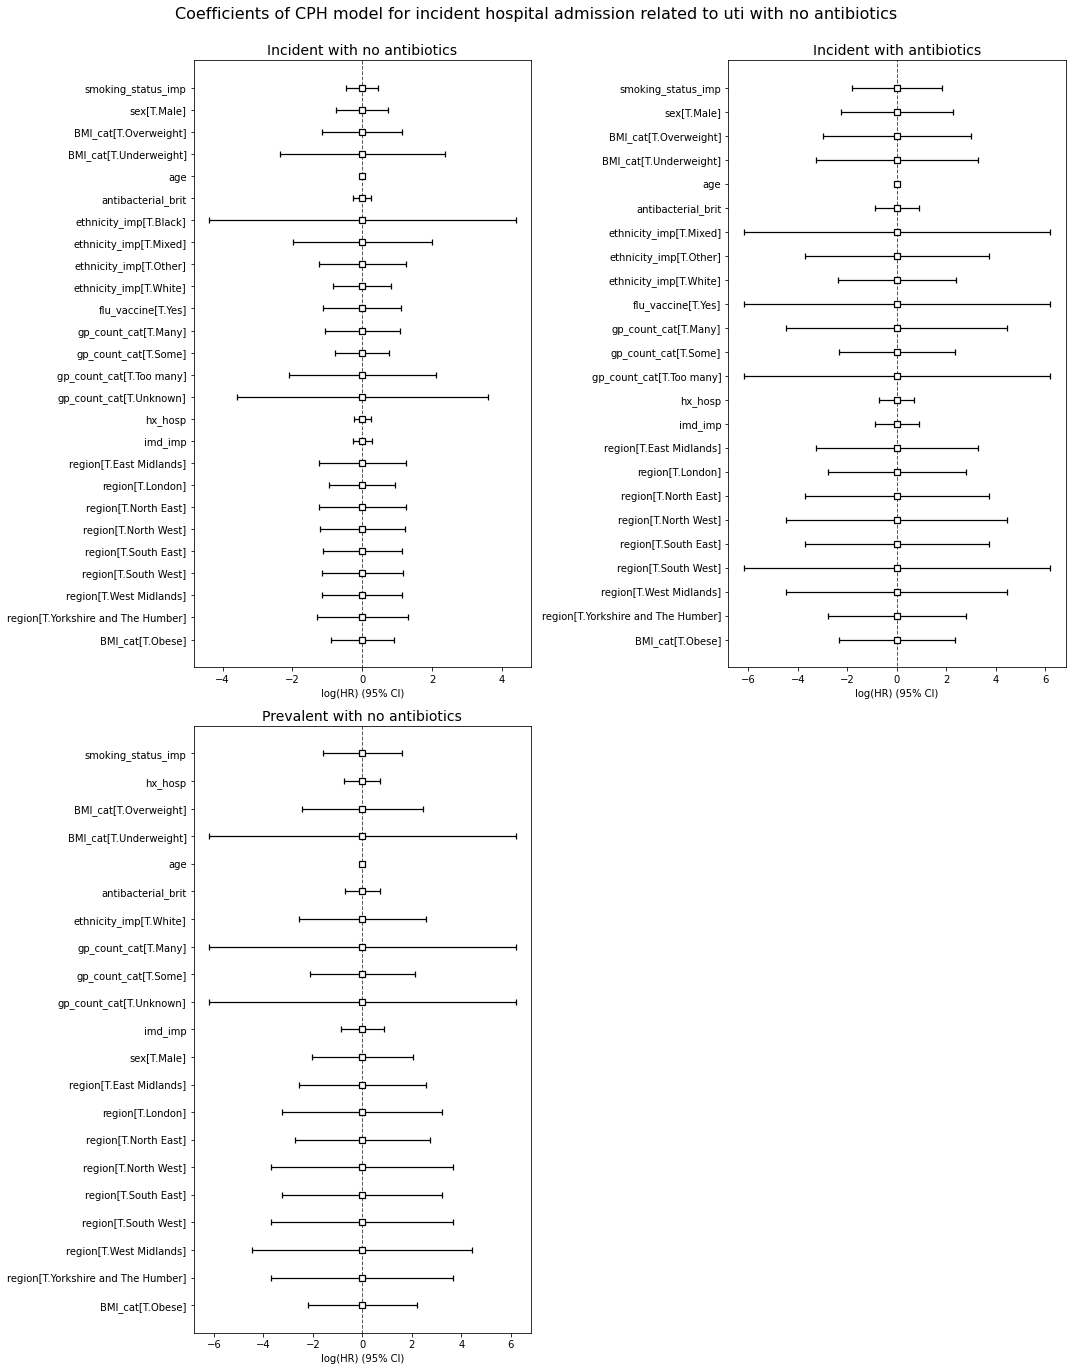

In [267]:
CoxModel("uti")
    # with open('output/hospitalisation_prediction/cph_uti_abs_incdt.pickle', 'rb') as f:
    #     cph_uti_abs_incdt = pickle.load(f)

In [38]:
# #predict unseen data with a trained cox model
# #https://stats.stackexchange.com/questions/488992/predictions-using-coxtimevaryingfitter-for-survival-analysis-in-python/489006#489006
# #https://lifelines.readthedocs.io/en/latest/lifelines.utils.html

# from lifelines.utils import k_fold_cross_validation

# with open('output/hospitalisation_prediction/cph_uti_no_abs_incdt.pickle', 'rb') as f:
#         cph_uti_no_abs_incdt = pickle.load(f)

# data_uti_no_abs_incdt.columns

# #
# dict_sex = {'Female': 0, 'Male': 1}
# data_uti_no_abs_incdt = data_uti_no_abs_incdt.replace({"sex": dict_sex})

# #keep required columns of data
# data_uti_no_abs_incdt = data_uti_no_abs_incdt[['age', 'sex', 
#                                                 # 'ethnicity', 'smoking_status', 'imd', 'region', 
#                                                 #  'BMI_cat', #'CCI', 
#                                                 #  'flu_vaccine', 'gp_count_cat', 'antibacterial_brit', 
#                                                 #  'hx_hosp', 
#                                                  'duration_uti_admitted', 'event_uti_admitted']]

# #split data into testing and training
# data_uti_no_abs_incdt_testing = data_uti_no_abs_incdt.loc[0:10]
# data_uti_no_abs_incdt_training = data_uti_no_abs_incdt.loc[10:3278]

# #predict unseen testing data with trained cox model
# cph_uti_no_abs_incdt.fit(data_uti_no_abs_incdt_training, duration_col='duration_uti_admitted', event_col='event_uti_admitted')
# cph_uti_no_abs_incdt.predict_partial_hazard(data_uti_no_abs_incdt_testing)

### 4-2- URTI

In [271]:
data_urti_no_abs_incdt.shape

(268, 29)

In [273]:
# CoxModel("urti")

In [ ]:
# hosp history, ab type history, 